## Deepsurv on Keras 2.x

### Mount google drive

In [17]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [19]:
!ls -l
!cp drive/Colab/deepsurv_keras.py .

total 32
drwxr-xr-x 1 root root 4096 Aug 13 09:27 datalab
-rw-r--r-- 1 root root 1209 Aug 13 09:27 deepsurv_keras.py
drwxr-xr-x 2 root root 4096 Aug 13 09:27 drive
-rw-r--r-- 1 root root 2969 Aug 13 09:18 Survival_Keras_lifelineExample.py
-rw-r--r-- 1 root root 2969 Aug 13 09:16 Survival_Keras_lifelineExample.py.1


### Import packages

In [23]:
!pip install lifelines

    100% |████████████████████████████████| 225kB 4.3MB/s 


In [ ]:
!rm -f deepsurv_keras.py
!wget -q https://www.dropbox.com/s/3f19vyaumogbogr/deepsurv_keras.py

In [1]:
# Survival Analysis using Keras
import numpy as np

from keras.optimizers import SGD, RMSprop

from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

import deepsurv_keras

Using TensorFlow backend.
/home/yoshida/anaconda3/envs/deepsurv_all/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Rossi dataset

In [2]:
rossi_dataset = load_rossi()
E = np.array(rossi_dataset["arrest"])
Y = np.array(rossi_dataset["week"])
X = np.array(rossi_dataset)
X = X.astype('float64')
X = X[:, 2:]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train, X_val, E_train, E_val = train_test_split(X, E, test_size=0.25, random_state=0)

# Standardize
scaler = preprocessing.StandardScaler().fit(X_train[:, [1, 6]])
X_train[:, [1, 6]] = scaler.transform(X_train[:, [1, 6]])
X_val[:, [1, 6]] = scaler.transform(X_val[:, [1, 6]])

# Sorting for NNL!
sort_idx = np.argsort(Y_train)[::-1]
X_train = X_train[sort_idx]
Y_train = Y_train[sort_idx]
E_train = E_train[sort_idx]

### Build and train DeepSurv on Keras 2.x

In [3]:
model = deepsurv_keras.build_model()

sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
model.compile(loss=deepsurv_keras.negative_log_likelihood(E_train), optimizer=sgd, metrics=['accuracy'])

Training...


Text(0,0.5,'loss')

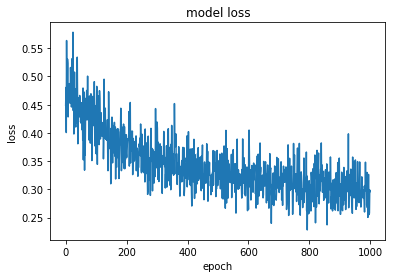

In [4]:
print('Training...')
history = model.fit(X_train, Y_train, batch_size=324, epochs=1000, shuffle=False, verbose=False)  # Shuffle False --> Important!!

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

### Testing

In [6]:
hr_pred = model.predict(X_train)
hr_pred = np.exp(hr_pred)
ci = concordance_index(Y_train, -hr_pred, E_train)

hr_pred2 = model.predict(X_val)
hr_pred2 = np.exp(hr_pred2)
ci2 = concordance_index(Y_val,-hr_pred2,E_val)
print('Concordance Index for training dataset:', ci)
print('Concordance Index for test dataset:', ci2)

# Cox Fitting
cf = CoxPHFitter()
cf.fit(rossi_dataset, 'week', event_col='arrest')

cf.print_summary()  # access the results using cf.summary

Concordance Index for training dataset: 0.5446854486891997
Concordance Index for test dataset: 0.6237765089722676
n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3794     0.6843    0.1914 -1.9826 0.0474     -0.7545     -0.0043   *
age  -0.0574     0.9442    0.0220 -2.6109 0.0090     -0.1006     -0.0143  **
race  0.3139     1.3688    0.3080  1.0192 0.3081     -0.2898      0.9176    
wexp -0.1498     0.8609    0.2122 -0.7058 0.4803     -0.5657      0.2662    
mar  -0.4337     0.6481    0.3819 -1.1357 0.2561     -1.1822      0.3147    
paro -0.0849     0.9186    0.1958 -0.4336 0.6646     -0.4685      0.2988    
prio  0.0915     1.0958    0.0286  3.1938 0.0014      0.0353      0.1476  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640
Likelihood ratio test = 33.266 on 7 df, p=0.00002
